#**CONTENUTO DEL NOTEBOOK**
In questo script confrontiamo le visualizzazioni di LDA e PCA, 2d e 3d dov'è possibile rispetto alle differenze tra le 3 condizioni muscolari. Vengono considerati i muscoli della coscia.
> In ordine abbiamo:
* Setting per Texture analyis
* Estrazione delle features
* Creazione dei Dataframes
* MANOVA
* Perchè non si può fare LDA 3D
* LDA 2D
* PCA 3D
* features più significative
* esclusione degli outliers (mostrare solo il 99° percentile)
* Altre tecniche di dimensionality reduction (t-SNE, UMAP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install umap-learn

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=6303b3bc20ed98bcb3846b45225ab277ae4054fda816a47c961fc8c7f83c4121
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=a5a306207fbd9502d2e71764bc40465641dd94d9da7c0914a0cf3e7e8ece413e
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [ ]:
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.8 MB/s eta 0:00:00


In [ ]:
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 KB 30.0 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp39-cp39-linux_x86_64.whl size=185765 sha256=a044162d9a02c7bf93d9cc2f1e34ecd5c1ba501c9def8f470cf6e329ea06e68c
  Stored in directory: /root/.cache/pip/wheels/62/0f/06/e8bdcc276fc814981e11a2fc4da7ad0da0a7e68a60fe90e747
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=3b52a2cb9ed56b4ee9e9cd5dfe8ad318d2fa5b0af1c3e86171c66c6e5bd9d35a
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc85

#Import funzioni utili

In [ ]:

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from radiomics import featureextractor
from __future__ import print_function
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from glob import glob
import pandas as pd


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from statsmodels.multivariate.manova import MANOVA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

import plotly.express as px
import plotly.io as pio

#Inizializzare i parametri della texture analysis

In [ ]:
#%%============================================================================
#             INIZIALIZZARE I PARAMETRI PER LA TEXTURE ANALYSIS
#==============================================================================

"""Sulla repository di Pyradiomics in "Example_settings" c'erano i parametri consigliati 
   per immagini MR con uno spessore di 5 mm , come quelle che compongono il nostro
   Dataset, quindi ho riportato manualmente quei settings"""

settings = {}
settings['binWidth'] = 25
settings['normalize'] = True
settings['normalizeScale'] = 100
  # Resampling:
  # Increasing the resampled spacing forces PyRadiomics to look at more coarse textures, which may or
  # may not increase accuracy and stability of your extracted features. Using a small spacing in large slices generates
  # many interpolated voxels, potentially 'masking' the signal contained in the image.
  # resampledPixelSpacing: [3, 3, 3]
settings['voxelArrayShift'] = 300

#%%============================================================================
#             INIZIALIZZARE L'EXTRACTOR SPECIFICANDO LE FEATURES
#==============================================================================
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)  # ** 'unpacks' the dictionary in the function call

extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
#per via del warning : "GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated"
#disabilito SumAverage specificando tutte le altre features
extractor.enableFeaturesByName(glcm=['Autocorrelation',
    'JointAverage',
    'ClusterProminence',
    'ClusterShade',
    'ClusterTendency',
    'Contrast',
    'Correlation',
    'DifferenceAverage',
    'DifferenceEntropy',
    'DifferenceVariance',
    'JointEnergy',
    'JointEntropy',
    'Imc1',
    'Imc2',
    'Idm',
    'Idmn',
    'Id',
    'Idn',
    'InverseVariance',
    'MaximumProbability',
    'SumEntropy',
    'SumSquares'])
extractor.enableFeatureClassByName('glrlm')
extractor.enableFeatureClassByName('glszm')
extractor.enableFeatureClassByName('gldm')
print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)



INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'binWidth': 25, 'normalize': True, 'normalizeScale': 100, 'voxelArrayShift': 300}


Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 100, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'voxelArrayShift': 300}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'glrlm': [], 'glszm': [], 'gldm': []}


#Consideriamo ogni muscolo nelle 3 condizioni muscolari dei soggetti


In [ ]:
directory = 'drive/MyDrive/tesi/GAMBA TA'

HV_img_path = sorted(glob(os.path.join(directory,"HV/imageshm","*.nii")))
HV_mask_path = sorted(glob(os.path.join(directory,"HV/labels","*nii")))

FSHD_img_path = sorted(glob(os.path.join(directory,"FSHD/imageshm","*.nii")))
FSHD_mask_path = sorted(glob(os.path.join(directory,"FSHD/labels","*.nii")))

MD1_img_path = sorted(glob(os.path.join(directory,"MD1/imageshm","*.nii")))
MD1_mask_path = sorted(glob(os.path.join(directory,"MD1/labels","*.nii")))

df_dir = os.path.join(directory,'Dataframe')

if not os.path.exists(df_dir):
  os.mkdir(df_dir)

Lista di muscoli

In [ ]:

labels = ["TA",                          # "Tibiale Anteriore",
          "TP",                          #"Tibiale Posteriore",
          "EL",                          #"Estensore Lungo",
          "PER",                         #"Peroneo",
          "FL-d",                        #"Flessore Lungo delle dita",
          "SOL",                         #"Soleo",
          "GM",                          #"Gastrocnemio Mediale",
          "GL",                          #"Gastrocnemio Laterale",
          "FL-a"]                        #"Flessore Lungo Dell'alluce", 

thigh_muscles= ["Tibiale Anteriore",
              "Tibiale Posteriore",
              "Estensore Lungo",
              "Peroneo",
              "Flessore Lungo delle dita",
              "Soleo",
              "Gastrocnemio Mediale",
              "Gastrocnemio Laterale",
              "Flessore Lungo Dell'alluce"] 

# thigh_muscles= ['Anterior Tibialis',
# 'Posterior Tibialis',
# 'Long Extensor',
# 'Peroneus',
# 'Flexor digitorum longus',
# 'Soleus',
# 'Medial Gastrocnemius',
# 'Lateral Gastrocnemius',
# 'Flexor hallucis longus',
# ] 

In [ ]:
feature_names = ['original_firstorder_10Percentile','original_firstorder_90Percentile','original_firstorder_Energy',
'original_firstorder_Entropy' ,
'original_firstorder_InterquartileRange' ,
'original_firstorder_Kurtosis' ,
'original_firstorder_Maximum' ,
'original_firstorder_Mean' ,
'original_firstorder_MeanAbsoluteDeviation' ,
'original_firstorder_Median' ,
'original_firstorder_Minimum' ,
'original_firstorder_Range' ,
'original_firstorder_RobustMeanAbsoluteDeviation',
'original_firstorder_RootMeanSquared' ,
'original_firstorder_Skewness' ,
'original_firstorder_TotalEnergy' ,
'original_firstorder_Uniformity' ,
'original_firstorder_Variance',
'original_glcm_Autocorrelation' ,
'original_glcm_ClusterProminence' ,
'original_glcm_ClusterShade' ,
'original_glcm_ClusterTendency' ,
'original_glcm_Contrast' ,
'original_glcm_Correlation' ,
'original_glcm_DifferenceAverage' ,
'original_glcm_DifferenceEntropy' ,
'original_glcm_DifferenceVariance',
'original_glcm_Id' ,
'original_glcm_Idm' ,
'original_glcm_Idmn',
'original_glcm_Idn' ,
'original_glcm_Imc1' ,
'original_glcm_Imc2',
'original_glcm_InverseVariance',
'original_glcm_JointAverage' ,
'original_glcm_JointEnergy',
'original_glcm_JointEntropy',
'original_glcm_MaximumProbability',
'original_glcm_SumEntropy' ,
'original_glcm_SumSquares',
'original_gldm_DependenceEntropy',
'original_gldm_DependenceNonUniformity',
'original_gldm_DependenceNonUniformityNormalized',
'original_gldm_DependenceVariance',
'original_gldm_GrayLevelNonUniformity',
'original_gldm_GrayLevelVariance',
'original_gldm_HighGrayLevelEmphasis',
'original_gldm_LargeDependenceEmphasis',
'original_gldm_LargeDependenceHighGrayLevelEmphasis',
'original_gldm_LargeDependenceLowGrayLevelEmphasis',
'original_gldm_LowGrayLevelEmphasis' ,
'original_gldm_SmallDependenceEmphasis',
'original_gldm_SmallDependenceHighGrayLevelEmphasis',
'original_gldm_SmallDependenceLowGrayLevelEmphasis',
'original_glrlm_GrayLevelNonUniformity',
'original_glrlm_GrayLevelNonUniformityNormalized',
'original_glrlm_GrayLevelVariance',
'original_glrlm_HighGrayLevelRunEmphasis',
'original_glrlm_LongRunEmphasis',
'original_glrlm_LongRunHighGrayLevelEmphasis',
'original_glrlm_LongRunLowGrayLevelEmphasis',
'original_glrlm_LowGrayLevelRunEmphasis',
'original_glrlm_RunEntropy',
'original_glrlm_RunLengthNonUniformity',
'original_glrlm_RunLengthNonUniformityNormalized',
'original_glrlm_RunPercentage',
'original_glrlm_RunVariance',
'original_glrlm_ShortRunEmphasis',
'original_glrlm_ShortRunHighGrayLevelEmphasis',
'original_glrlm_ShortRunLowGrayLevelEmphasis',
'original_glszm_GrayLevelNonUniformity',
'original_glszm_GrayLevelNonUniformityNormalized',
'original_glszm_GrayLevelVariance' ,
'original_glszm_HighGrayLevelZoneEmphasis',
'original_glszm_LargeAreaEmphasis',
'original_glszm_LargeAreaHighGrayLevelEmphasis',
'original_glszm_LargeAreaLowGrayLevelEmphasis' ,
'original_glszm_LowGrayLevelZoneEmphasis',
'original_glszm_SizeZoneNonUniformity' ,
'original_glszm_SizeZoneNonUniformityNormalized' ,
'original_glszm_SmallAreaEmphasis' ,
'original_glszm_SmallAreaHighGrayLevelEmphasis' ,
'original_glszm_SmallAreaLowGrayLevelEmphasis' ,
'original_glszm_ZoneEntropy' ,
'original_glszm_ZonePercentage' , 'original_glszm_ZoneVariance']

#Estrarre le features e costruire i Dataframes
otterremo un dataframe per ogni muscolo con la seguente struttura: 
> | 'Subject' | 'F1' | ... | 'FN' | 'Class' |

In [ ]:
#%%============================================================================
#                             ESTRARRE LE FEATURES
#==============================================================================
exceptions = []
df_list = []     #--> è una lista di dataframe che deve contenere 12 elementi: un dataframe per ogni muscolo
for a,label in enumerate(labels):
   results = {}
   results['HV'] = {}
   results['MD1'] = {}
   results['FSHD'] = {}

   # CREARE UN DICTIONARY CHE ACCOGLIERA' I RISULTATI.
   # Poi il Dictionary sarà riarrangiato in un DataFrame per poter agevolmente applicare la tecnica di dimensionality reduction

   subject_HV = []  #mantenere questa lista torna utile per la creazione del dataframe --> iterando prendo comodamente tutti i soggetti
   for i in range(len(HV_img_path)):   #avrei potuto usare indifferentemente HV_mask_path, che ha la stessa lunghezza 
       subject_i = os.path.basename(HV_img_path[i]).split('_')[1]  #--> '001'
       subject_HV.append(subject_i)
       
   for k,j in enumerate(subject_HV):
       try:
         results['HV'][j] = extractor.execute(HV_img_path[k], HV_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (HV)'.format(str(a+1),j) 
         exceptions.append(exception)
           
     

   subject_MD1 = []
   for i in range(len(MD1_img_path)):
       img_name = os.path.splitext(MD1_img_path[i])[0]
       pz = img_name.split('_')[1] #-->'001'
       num = img_name.split('_')[3]  #-->'1','2' o '3'
       subject_i = '_'.join((pz,num)) 
       subject_MD1.append(subject_i)
       
   for k,j in enumerate(subject_MD1):    
       try:
         results['MD1'][j] = extractor.execute(MD1_img_path[k], MD1_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (MD1)'.format(str(a+1),j) 
         exceptions.append(exception)
           
       

   subject_FSHD = []
   for i in range(len(FSHD_img_path)):
       img_name = os.path.splitext(FSHD_img_path[i])[0]
       pz = img_name.split('_')[1] #-->'001'
       side = img_name.split('_')[4]  #-->'L' o 'R'
       subject_i = '_'.join((pz,side))
       subject_FSHD.append(subject_i)
       
   for k,j in enumerate(subject_FSHD):    
       try:
         results['FSHD'][j] = extractor.execute(FSHD_img_path[k], FSHD_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (FSHD)'.format(str(a+1),j) 
         exceptions.append(exception)
           
   #%%============================================================================
   #                          COSTRUIRE IL DATAFRAME
   #==============================================================================
   """
       Dopo aver calcolato le features per tutti i pazienti selezionati
       devo organizzare i dati in una tabella o dataframe con pandas
   """

   # Delle 108 features che estraggo, solo alcume mi interessano --> feature_names (86)
   # le estraggo e le riordino 
   feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results['HV']['005'] )))

   # colonne del dataframe
   # |'Subject'|'F1'| ... |'FN'|'Class'|

   columns = ['Subject']
   for feature in feature_names:
       columns.append(feature)
   columns.append('Class')

   # riorganizzare i risultati: dal dict al df
   # costruisco riga per riga i dati che riempiranno il DataFrame

   data = []

   for subject in subject_HV:
     if subject in results['HV']:  
       row = [subject]
       for i in feature_names:
           feature = results['HV'][subject][i]
           row.append(feature)
       row.append('HV')
       data.append(row)


   for subject in subject_MD1:
     if subject in results['MD1']:
       row = [subject]
       for i in feature_names:
           feature = results['MD1'][subject][i]
           row.append(feature)
       row.append('MD1')
       data.append(row)
       
       
   for subject in subject_FSHD:
     if subject in results['FSHD']:
       row = [subject]
       for i in feature_names:
           feature = results['FSHD'][subject][i]
           row.append(feature)
       row.append('FSHD')
       data.append(row)
       
   
   
   df=pd.DataFrame(data,columns=columns) #creo il dataframe
   df.to_csv(os.path.join(df_dir,'Dataframe_{}.csv'.format(label)))
   df_list.append(df)
   

Output streaming troncato alle ultime 5000 righe.
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 4
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 4
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder

# MANOVA

In [ ]:
df_paths = glob(os.path.join(df_dir,'*.csv'))

# df_list = []

# for path in df_paths:
#   df = pd.read_csv(path, index_col=0)
#   df_list.append(df)

for path in df_paths:
    label = os.path.splitext(path)[0].split('_')[1]  #-->'VL'
    df = pd.read_csv(path, index_col=0)
    #df.head()

    maov = MANOVA.from_formula('original_firstorder_10Percentile + \
    original_firstorder_90Percentile + \
    original_firstorder_Energy + \
    original_firstorder_Entropy + \
    original_firstorder_InterquartileRange + \
    original_firstorder_Kurtosis + \
    original_firstorder_Maximum + \
    original_firstorder_Mean + \
    original_firstorder_MeanAbsoluteDeviation + \
    original_firstorder_Median + \
    original_firstorder_Minimum + \
    original_firstorder_Range + \
    original_firstorder_RobustMeanAbsoluteDeviation + \
    original_firstorder_RootMeanSquared + \
    original_firstorder_Skewness + \
    original_firstorder_TotalEnergy + \
    original_firstorder_Uniformity + \
    original_firstorder_Variance + \
    original_glcm_Autocorrelation + \
    original_glcm_ClusterProminence + \
    original_glcm_ClusterShade + \
    original_glcm_ClusterTendency + \
    original_glcm_Contrast + \
    original_glcm_Correlation + \
    original_glcm_DifferenceAverage + \
    original_glcm_DifferenceEntropy + \
    original_glcm_DifferenceVariance + \
    original_glcm_Id + \
    original_glcm_Idm + \
    original_glcm_Idmn + \
    original_glcm_Idn + \
    original_glcm_Imc1 + \
    original_glcm_Imc2 + \
    original_glcm_InverseVariance + \
    original_glcm_JointAverage + \
    original_glcm_JointEnergy + \
    original_glcm_JointEntropy + \
    original_glcm_MaximumProbability + \
    original_glcm_SumEntropy + \
    original_glcm_SumSquares + \
    original_gldm_DependenceEntropy + \
    original_gldm_DependenceNonUniformity + \
    original_gldm_DependenceNonUniformityNormalized + \
    original_gldm_DependenceVariance + \
    original_gldm_GrayLevelNonUniformity + \
    original_gldm_GrayLevelVariance + \
    original_gldm_HighGrayLevelEmphasis + \
    original_gldm_LargeDependenceEmphasis + \
    original_gldm_LargeDependenceHighGrayLevelEmphasis + \
    original_gldm_LargeDependenceLowGrayLevelEmphasis + \
    original_gldm_LowGrayLevelEmphasis + \
    original_gldm_SmallDependenceEmphasis + \
    original_gldm_SmallDependenceHighGrayLevelEmphasis + \
    original_gldm_SmallDependenceLowGrayLevelEmphasis + \
    original_glrlm_GrayLevelNonUniformity + \
    original_glrlm_GrayLevelNonUniformityNormalized + \
    original_glrlm_GrayLevelVariance + \
    original_glrlm_HighGrayLevelRunEmphasis + \
    original_glrlm_LongRunEmphasis + \
    original_glrlm_LongRunHighGrayLevelEmphasis + \
    original_glrlm_LongRunLowGrayLevelEmphasis + \
    original_glrlm_LowGrayLevelRunEmphasis + \
    original_glrlm_RunEntropy + \
    original_glrlm_RunLengthNonUniformity + \
    original_glrlm_RunLengthNonUniformityNormalized + \
    original_glrlm_RunPercentage + \
    original_glrlm_RunVariance + \
    original_glrlm_ShortRunEmphasis + \
    original_glrlm_ShortRunHighGrayLevelEmphasis + \
    original_glrlm_ShortRunLowGrayLevelEmphasis + \
    original_glszm_GrayLevelNonUniformity + \
    original_glszm_GrayLevelNonUniformityNormalized + \
    original_glszm_GrayLevelVariance + \
    original_glszm_HighGrayLevelZoneEmphasis + \
    original_glszm_LargeAreaEmphasis + \
    original_glszm_LargeAreaHighGrayLevelEmphasis + \
    original_glszm_LargeAreaLowGrayLevelEmphasis + \
    original_glszm_LowGrayLevelZoneEmphasis + \
    original_glszm_SizeZoneNonUniformity + \
    original_glszm_SizeZoneNonUniformityNormalized + \
    original_glszm_SmallAreaEmphasis + \
    original_glszm_SmallAreaHighGrayLevelEmphasis + \
    original_glszm_SmallAreaLowGrayLevelEmphasis + \
    original_glszm_ZoneEntropy + \
    original_glszm_ZonePercentage + original_glszm_ZoneVariance  ~ Class', data=df)

    print(label)                           
    print(maov.mv_test())

TA
                          Multivariate linear model
                                                                             
-----------------------------------------------------------------------------
       Intercept            Value      Num DF  Den DF      F Value     Pr > F
-----------------------------------------------------------------------------
          Wilks' lambda         0.0000 5.0000 102.0000 7981083305.1099 0.0000
         Pillai's trace         1.6709 5.0000 102.0000        -50.8063 1.0000
 Hotelling-Lawley trace 133987851.2726 5.0000 102.0000 2733352165.9615 0.0000
    Roy's greatest root 133987849.3918 5.0000 102.0000 2733352127.5935 0.0000
-----------------------------------------------------------------------------
                                                                             
-------------------------------------------------------------------------------
            Class             Value      Num DF    Den DF     F Value    Pr > F
-----

#Estrazione features mirata con test statistici

STEP:
* separo le features in MD1 e FSHD. considero la stessa features (tipo Kurtosis) per i soggetti FSHD e per i soggetti MD1;
* prima di applicare il t-test verificare le ipotesi:
* ipotesi di normalità: test di Shapiro-Wilk
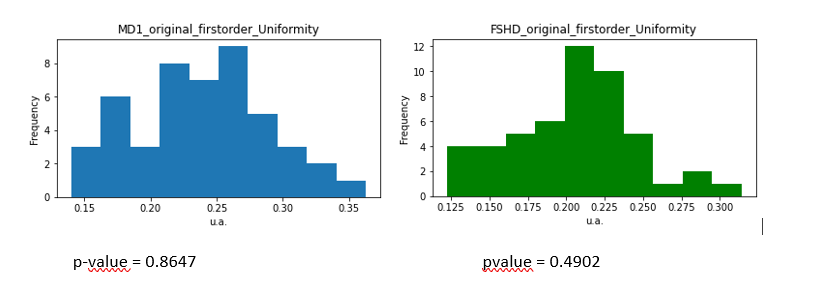
  * se la stessa features è normale in entrambi i gruppi allora la considero, altrimenti no
* omogeneità della varianza --> test di Levene
  * se è positivo (p-value < 0.05) --> varianza non omogenea
  * se è negativo (p-value > 0.05) --> varianza omogenea
* mantengo solo le features che prese singolarmente mostrano una differenza statisticamente significativa
* MANOVA tra le features "sopravvissute" (qui non c'è) per vedere se anche tutte insieme mostrano differenze significative
* pca su questo subset di features 
> LIMITE:
a volte le features estratte solo troppo poco numerose e non si vede una buona distinzione dove invece si dovrebbe --> GRANDE ADDUTTORE

In [ ]:
from scipy import stats 
features_per_muscolo ={}

features_normali_per_muscolo ={}

unione_features = []

for path in df_paths:
    label = os.path.splitext(path)[0].split('_')[1]
    df = pd.read_csv(path)

    for i in range(len(feature_names)):
        print('---------------------------------------------------------------')
        print(feature_names[i])
        print(df.groupby('Class')[feature_names[i]].describe())
        
    MD1 = df[(df['Class'] == 'MD1')]
    FSHD = df[(df['Class'] == 'FSHD')]


    #omogeneità della varianza
    for i in range(len(feature_names)):
        print('---------------------------------------------------------------')
        print(feature_names[i])
        print(stats.levene(MD1[feature_names[i]], FSHD[feature_names[i]])) # ,equal_var = False##--> la varianza dei due gruppi in alcuni casi è differente
        
        
    
        
    #hanno una distribuzione normale?
    # for i in range(len(feature_names)):
    #     #plt.xlabel("Length (units)")
    #     #plt.savefig('Setosa_sepal_width')
    #     plt.figure("check", (6, 3))
    #     MD1[feature_names[i]].plot(kind="hist", title="MD1_{}".format(feature_names[i]))   
    #     plt.show()

    #     plt.figure("check", (6, 3))
    #     FSHD[feature_names[i]].plot(kind="hist", title="FSHD_{}".format(feature_names[i]), color="green")
    #     plt.show()
        
    #visivamente, la maggior parte delle distribuzioni sono normali
    #confermiamo la normalità con il test di shapiro welch
    
    features_normali = []
    for i in range(len(feature_names)):
        print('---------------------------------------------------------------')
        print(feature_names[i])
        print('MD1')
        print(stats.shapiro(MD1[feature_names[i]]))
        statistic,pvalue_md1 = stats.shapiro(MD1[feature_names[i]])
        print('FSHD')
        print(stats.shapiro(FSHD[feature_names[i]]))
        statistic,pvalue_fshd = stats.shapiro(FSHD[feature_names[i]])
        if pvalue_md1 > 0.05 and pvalue_fshd > 0.05:     #vuol dire che sono distribuzioni normali [https://pythonfordatascienceorg.wordpress.com/independent-t-test-python/]
            features_normali.append(feature_names[i])
            
    features_normali_per_muscolo[label]=features_normali   
                   


    #procediamo con il t-test vero e proprio
    #quali features sono significative per discriminare
    #il vasto intermedio in un soggetto con MD1 da quello con FSHD?

    # feature_name_interesting = []
    # for i in range(len(feature_names)):
    #     print('---------------------------------------------------------------')
    #     print(feature_names[i])
    #     print(stats.ttest_ind(MD1[feature_names[i]], FSHD[feature_names[i]],equal_var= False)) # ,equal_var = False##--> la varianza dei due gruppi in alcuni casi è differente
    #     statistics,pvalue = stats.ttest_ind(MD1[feature_names[i]], FSHD[feature_names[i]])
    #     if pvalue < 0.05:  #--> differenza significativa!
    #       feature_name_interesting.append(feature_names[i])
    #       if feature_names[i] not in unione_features:
    #           unione_features.append(feature_names[i])
          
    feature_name_interesting = []
    for i in range(len(features_normali)):
        print('---------------------------------------------------------------')
        print(features_normali[i])
        st,pv = stats.levene(MD1[features_normali[i]], FSHD[features_normali[i]])  #la varianza è omogenea? sì--> t test, no--> t-test di Wilk's (equal_var = False)
        if pv > 0.05:  #il test non è significativo significa che c'è omogeneità
            print(stats.ttest_ind(MD1[features_normali[i]], FSHD[features_normali[i]])) 
            statistics,pvalue = stats.ttest_ind(MD1[features_normali[i]], FSHD[features_normali[i]])
        else:
            print(stats.ttest_ind(MD1[features_normali[i]], FSHD[features_normali[i]],equal_var= False))
            statistics,pvalue = stats.ttest_ind(MD1[features_normali[i]], FSHD[features_normali[i]],equal_var= False)
        
        if pvalue < 0.05:  #--> differenza significativa!
          feature_name_interesting.append(features_normali[i])
          if features_normali[i] not in unione_features:
              unione_features.append(features_normali[i])
    
    features_per_muscolo[label] = feature_name_interesting
       




Output streaming troncato alle ultime 5000 righe.

            max  
Class            
FSHD   0.904378  
HV     0.443265  
MD1    0.786360  
---------------------------------------------------------------
original_glrlm_LowGrayLevelRunEmphasis
       count      mean       std       min       25%       50%       75%  \
Class                                                                      
FSHD    50.0  0.031016  0.037092  0.006443  0.013250  0.021462  0.028526   
HV      10.0  0.075967  0.033024  0.021205  0.058690  0.073937  0.094091   
MD1     49.0  0.043324  0.030569  0.011021  0.021218  0.035407  0.058065   

            max  
Class            
FSHD   0.182376  
HV     0.124518  
MD1    0.182618  
---------------------------------------------------------------
original_glrlm_RunEntropy
       count      mean       std       min       25%       50%       75%  \
Class                                                                      
FSHD    50.0  4.519107  0.257000  3.985110 

#PCA con le features estratte

In [ ]:
      
pca_results = {}

for path in df_paths:
    label = os.path.splitext(path)[0].split('_')[1]
    df = pd.read_csv(path)
    
    # if label != 'TP':

    #   df_ridotto = df[features_per_muscolo[label]]
    
    #   data_subset = df_ridotto.values  
    #   data_subset_scaled = MinMaxScaler().fit_transform(data_subset)   #normalizzo le variabili perchè PCA risente della scala. 
  
    #   pca = PCA(n_components = 2)
    #   pca_results_2d = pca.fit_transform(data_subset_scaled)   #ottengo 3 principal components
    #   pca_results[label] = pca_results_2d  
    df_ridotto = df[features_per_muscolo[label]]
    
    data_subset = df_ridotto.values  
    data_subset_scaled = MinMaxScaler().fit_transform(data_subset)   #normalizzo le variabili perchè PCA risente della scala. 
  
    pca = PCA(n_components = 2)
    pca_results_2d = pca.fit_transform(data_subset_scaled)   #ottengo 3 principal components
    pca_results[label] = pca_results_2d 


In [ ]:
#%%=============================================================================
#                   FEATURES PIU' RAPPRESENTATIVE E PCA
#===============================================================================
#FEATURES PIU' RILEVANTI =! PRINCIPAL COMPONENTS

#Features rilevanti --> sono un sottoinsieme delle features di partenza e sono semplicemente quelle che pesano 
#                       maggiormente nella combinazione lineare per ottenere PCi
#Principal components --> il loro numero lo decidiamo noi e permettono di rappresentare in maniera più semplice i dati
#                         ottimizzando la combinazione delle features di partenza in modo da mantenere la maggior
#                         parte delle informazioni iniziali.

relevant_features_PC1 = {}
relevant_features_PC2 = {}


#pca_results_list = []


for path in df_paths:
  label = os.path.splitext(path)[0].split('_')[1]
  df = pd.read_csv(path)

  data_subset = df[features_per_muscolo[label]].values
  #data_subset_scaled = StandardScaler().fit_transform(data_subset)
  data_subset_scaled = MinMaxScaler().fit_transform(data_subset)   #normalizzo le variabili perchè PCA risente della scala. 
  
  pca = PCA(n_components = 2)
  pca_results_2d = pca.fit_transform(data_subset_scaled)   #ottengo 3 principal components
  #pca_results_list.append(pca_results_2d)
  #-----------------Organizzazione utile per le relevant components-------------
  pca_df = pd.DataFrame(
    data=pca_results_2d, 
    columns=['PC1', 'PC2'])
  pca_df['Class'] = df['Class']
  # Principal components correlation coefficients
  loadings = pca.components_   #coefficienti autovettori
 
  # Number of features before PCA
  n_features = pca.n_features_
 
  # PC names
  pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
  # Match PC names to loadings
  pc_loadings = dict(zip(pc_list, loadings))
 
  # Dataframe con features e rispettivi pesi per ogni PC
  loadings_df = pd.DataFrame.from_dict(pc_loadings)
  loadings_df['feature_names'] = features_per_muscolo[label]
  loadings_df = loadings_df.set_index('feature_names')

  #per ogni dataframe (relativo ad un muscolo) estraggo le features più rilevanti e le metto nel dict
  #Criterio di estrazione:
  #considero il peso massimo (max(loadings_df['PCi']))
  #estraggo tutte le features associate ai pesi più elevati (ovvero maggiori di (peso_massimo - delta_piccolo))
  relevant_features_PC1[label] =  loadings_df.loc[loadings_df['PC1']>max(loadings_df['PC1'])-0.05,['PC1']]
  relevant_features_PC2[label] =  loadings_df.loc[loadings_df['PC2']>max(loadings_df['PC2'])-0.05,['PC2']]
  #relevant_features_PC3[label] =  loadings_df.loc[loadings_df['PC3']>max(loadings_df['PC3'])-0.05,['PC3']]
  #-----------------------------------------------------------------------------

  #da 86 features passo a 3 principal components. Quanta informazione perdo? --> explained_variance_ratio_
  print('PCA 2 components explained variance : ',pca.explained_variance_ratio_)
  print('Cumulative explained variation for 2 principal components: ',np.sum(pca.explained_variance_ratio_)) 

PCA 2 components explained variance :  [0.55453783 0.19939682]
Cumulative explained variation for 2 principal components:  0.7539346442677617
PCA 2 components explained variance :  [0.65004789 0.34995211]
Cumulative explained variation for 2 principal components:  0.9999999999999999
PCA 2 components explained variance :  [0.6969639  0.18116703]
Cumulative explained variation for 2 principal components:  0.8781309309319935
PCA 2 components explained variance :  [0.45867284 0.24886042]
Cumulative explained variation for 2 principal components:  0.7075332608733214
PCA 2 components explained variance :  [0.56524669 0.36592807]
Cumulative explained variation for 2 principal components:  0.931174751618783
PCA 2 components explained variance :  [0.51272288 0.25458837]
Cumulative explained variation for 2 principal components:  0.7673112481301314
PCA 2 components explained variance :  [0.48879838 0.20954672]
Cumulative explained variation for 2 principal components:  0.6983451034710764
PCA 2 c

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/pytho

In [ ]:
for i,muscle in enumerate(labels):
  print(muscle)
  print(relevant_features_PC1[muscle])
  print('---------------------------------------------------')
  print('Number of most relevant features: ',relevant_features_PC1[muscle].shape[0])

TA
                         PC1
feature_names               
original_glcm_Idmn  0.387101
original_glcm_Idn   0.419625
original_glcm_Imc2  0.390093
---------------------------------------------------
Number of most relevant features:  3
TP
                         PC1
feature_names               
original_glcm_Idmn  0.770559
---------------------------------------------------
Number of most relevant features:  1
EL
                                          PC1
feature_names                                
original_firstorder_Mean             0.507055
original_firstorder_Median           0.476815
original_firstorder_RootMeanSquared  0.502643
---------------------------------------------------
Number of most relevant features:  3
PER
                                          PC1
feature_names                                
original_firstorder_90Percentile     0.335855
original_firstorder_Maximum          0.368057
original_firstorder_Mean             0.318190
original_firstorder_RootMean

In [ ]:
for i,muscle in enumerate(labels):
  print(muscle)
  print(relevant_features_PC2[muscle])
  print('---------------------------------------------------')
  print('Number of most relevant features: ',relevant_features_PC2[muscle].shape[0])

TA
                                            PC2
feature_names                                  
original_gldm_DependenceNonUniformity  0.587948
---------------------------------------------------
Number of most relevant features:  1
TP
                         PC2
feature_names               
original_glcm_Idmn -0.637369
---------------------------------------------------
Number of most relevant features:  1
EL
                                                      PC2
feature_names                                            
original_gldm_DependenceNonUniformityNormalized  0.648189
---------------------------------------------------
Number of most relevant features:  1
PER
                                                      PC2
feature_names                                            
original_glcm_Idmn                               0.328710
original_glszm_GrayLevelNonUniformityNormalized  0.299908
---------------------------------------------------
Number of most relevant feature

#Elimino gli outliers

In [ ]:
zoom_in_percentile_range = (0, 99)
df_plot_list = []
for path in df_paths:
    
    label = os.path.splitext(path)[0].split('_')[1]
    df = pd.read_csv(path)#df mi interessa solo per la colonna delle classi

   # if label != 'TP': 
    X = pca_results[label]
    cutoffs_0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_1 = np.percentile(X[:, 1], zoom_in_percentile_range)
    #cutoffs_2 = np.percentile(X[:, 2], zoom_in_percentile_range)


    no_outliers_mask = np.all(X > [cutoffs_0[0], cutoffs_1[0]], axis=1) & np.all(
            X < [cutoffs_0[1], cutoffs_1[1]], axis=1)

    pca_results_no_outliers = X[no_outliers_mask]

    #creo un dataframe con pca_results_no_outliers e le classi corrispondenti

    df_plot = pd.DataFrame(pca_results_no_outliers,columns=['pca_1','pca_2'])
    df_plot['Class'] = (df['Class'].values)[no_outliers_mask]
    df_plot_list.append(df_plot)
    #df plot segue lo stesso ordine di df_path quindi parte dal ADD


#VISUALIZZAZIONE

In [ ]:
# labels = ["TA",                          # "Tibiale Anteriore",
#           "EL",                          #"Estensore Lungo",
#           "PER",                         #"Peroneo",
#           "FL-d",                        #"Flessore Lungo delle dita",
#           "SOL",                         #"Soleo",
#           "GM",                          #"Gastrocnemio Mediale",
#           "GL",                          #"Gastrocnemio Laterale",
#           "FL-a"]                        #"Flessore Lungo Dell'alluce", 

# thigh_muscles= ["Tibiale Anteriore",
#               "Estensore Lungo",
#               "Peroneo",
#               "Flessore Lungo delle dita",
#               "Soleo",
#               "Gastrocnemio Mediale",
#               "Gastrocnemio Laterale",
#               "Flessore Lungo Dell'alluce"]


In [ ]:
for path in df_paths:
    label = os.path.splitext(path)[0].split('_')[1]
    print(label)

#l'ordine dei df in df_plot_list segue quello delle cartelle, che, in questo caso, segue quello delle liste labels e thigh muscles

TA
TP
EL
PER
FL-d
SOL
GM
GL
FL-a


In [ ]:
    
for df_plot,label,muscle in zip(df_plot_list,labels,thigh_muscles):
    #label = os.path.splitext(path)[0].split('_')[1]
    fig = px.scatter(
                df_plot, x= 'pca_1', y= 'pca_2',
                color= 'Class', labels={'color': 'Class'},width = 10,height = 10)
    fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01))
    fig.update_traces(marker_size=16)
    title = (muscle  + '({})'.format(label) + ' t-test , N_features = {}'.format(len(features_per_muscolo[label])) )
    fig.update_layout(title= title, width=1400, height=500)

    fig.show()